# PYTORCH TENSORBOARD SUPPORT

本节课可以在[youtube](https://www.youtube.com/watch?v=6CEld3hZgqc)上观看。

## Before You Start

为了运行本教程，你需要安装PyTorch、TorchVision、Matplotlib和TensorBoard。

使用 ``conda`` 安装：

In [ ]:
conda install pytorch torchvision -c pytorch
conda install matplotlib tensorboard

使用 ``pip`` 安装：

In [ ]:
pip install torch torchvision matplotlib tensorboard

一旦依赖项安装完毕，在安装它们的 Python 环境中重新启动这篇教程。

## Introduction

在这个笔记本中，我们将针对Fashion-MNIST数据集训练LeNet-5网络的一个变种。Fashion-MNIST是一组描述各种服装的图像，有10个类别的标签表示所描述的服装的类型。

In [3]:
# PyTorch模型和训练所必要的
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 图像数据集和图像操作
import torchvision
import torchvision.transforms as transforms

# 图像展示
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard 支持
from torch.utils.tensorboard import SummaryWriter

# 如果你使用的是已经安装了TensorFlow的环境、
# 比如Google Colab，取消以下代码以避免
# 在将嵌入文件保存到你的TensorBoard目录时出现的错误

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

## Showing Images in TensorBoard

让我们开始从我们的数据集中添加样本图片到TensorBoard：

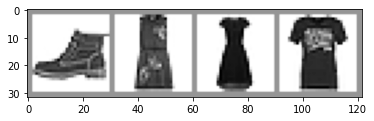

In [5]:
# 获取数据集并把它们准备好用于使用
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# 在./data中存储独立的训练和验证集。
training_set = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(
    training_set, 
    batch_size=4,
    shuffle=True,
    num_workers=2)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=4,
    shuffle=False,
    num_workers=2)

# 类别标签
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# 内置图像显示助手函数
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
# 抽取一个有四张图片的批量
dataiter = iter(training_loader)
images, labels = next(dataiter)

# 从图像中创建一个网格，并展示它们
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

上面，我们使用TorchVision和Matplotlib来创建一个我们输入数据的minibatch的视觉网格。下面，我们使用 ``SummaryWriter``上的 ``add_image()`` 调用来记录图像供TensorBoard使用，我们还调用 ``flush()`` 来确保它被立即写入磁盘。

In [6]:
# 默认的log_dir参数是"runs"， 但是最好能具体一点
# torch.utils.tensorboard.SummaryWriter 已经在上面被导入
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# 将图像数据写入TensorBoard日志目录
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# 要查看，在命令行上用以下方法启动TensorBoard：
# tensorboard --logdir=runs
# ...并打开一个浏览器标签页，http://localhost:6006/

如果你在命令行启动TensorBoard并在一个新的浏览器标签页中打开它（通常在<localhost:6006>），你应该在IMAGES标签下看到图像网格。

## Graphing Scalars to Visualize Training

TensorBoard对于跟踪你的训练进度和效果非常有用。下面，我们将运行一个训练循环，跟踪一些指标，并保存数据供TensorBoard使用。

让我们定义一个模型以及一个优化器和损失函数来分类我们的图像：

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

现在让我们训练一个单一的世代，并每1000个批次评估一次训练与验证集的损失：

In [17]:
print(len(validation_loader))
for epoch in range(1):  # 循环数据集的次数
    running_loss = 0.0
    
    for i, data in enumerate(training_loader, 0):
        # 基本的训练循环
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:  # 每1000个mini-batches...
            print('Batch {}'.format(i + 1))
            running_vloss = 0.0
            
            net.train(False)  # 对于验证不需要跟踪梯度
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True)  # 为训练重新打开梯度
            
            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)
            
            # 记录每个批次的平均运行损失
            writer.add_scalars('Training vs. Validation Loss',
                               { 'Training' : avg_loss, 'Validation' : avg_vloss},
                               epoch * len(training_loader) + i)
            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


切换到你打开的TensorBoard，看一下SCALARS选项卡。

## Visualizing Your Model

TensorBoard也可以用来检查模型中的数据流。要做到这一点，需要对模型和样本输入调用 ``add_graph()`` 方法。当你打开

In [18]:
# 同样，抓取一个小型的图像批次
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() 将会跟踪整个模型的样本输入，
# 并且将它们记录为一张图
writer.add_graph(net, images)
writer.flush()

当你切换到TensorBoard，可以看到一个GRAPHS标签。双击 "NET "节点以查看模型中的层和数据流。

## Visualizing Your Dataset with Embeddings

我们使用的28乘28的图像块可以被建模为784维的向量（28\*28=784）。将其投射到一个较低维度的表示上可能会有启发。``add_embedding()`` 方法将把一组数据投射到方差最大的三个维度上，并将它们显示为一个交互式的三维图表。``add_embedding()`` 方法通过投射到方差最大的三个维度来自动完成这一工作。

下面，我们将从我们的数据中抽取一个样本，并生成这样一个嵌入：

In [20]:
# 选择数据的一个随机子序列和它们相应的标签
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data))
    return data[perm][:n],  labels[perm][:n]

# 提取一个随机的数据子集
images, labels = select_n_random(training_set.data, training_set.targets)

# 为每个图片获取类标签
class_labels = [classes[label] for label in labels]

# 记录嵌入
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))
writer.flush()
writer.close()

现在，如果你切换到TensorBoard并选择PROJECTOR选项卡，你应该看到投影的3D表现。你可以旋转和缩放该模型。在大尺度和小尺度上检查它，看看你是否能发现投影数据的模式和标签的聚类。

为了获得更好的可见度，建议：

- 从左边的 "Color by" 下拉菜单中选择 "label"。

- 沿着顶部切换 "夜间模式 "图标，将浅色图像放在深色背景上。

## Other Resources

更多信息请看:

- PyTorch文档 [torch.utils.tensorboard.SummaryWriter](https://pytorch.org/docs/stable/tensorboard.html?highlight=summarywriter)

- Tensorboard 教程 [PyTorch.org Tutorials](https://pytorch.org/tutorials/)

- 更多TensorBoard信息, 请看 [TensorBoard documentation](https://www.tensorflow.org/tensorboard)